In [1]:
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H,S,Sdag, sqrtX,sqrtXdag,sqrtY,sqrtYdag #1量子ビット Clifford演算
from qulacs.gate import T,Tdag #1量子ビット 非Clifford演算
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算
from qulacs.gate import CNOT, CZ, SWAP #2量子ビット演算
from qulacs import QuantumCircuit
import matplotlib.pyplot as plt
import numpy as np

### 一番簡単な Noise Mitigation を実装してみる
ここでは qulacs を用いて、ノイズを入れる方法を紹介し、そのノイズの影響を noise mitigation (Efficient Variational Quantum Simulator Incorporating Active Error Minimization, Ying Li and Simon C. Benjamin, PRX 2017)を用いて補償する方法を紹介する。

### 理想的な回路の構築

In [43]:
nqubits = 1
state = QuantumState(nqubits)
state.set_zero_state
circuit  = QuantumCircuit(nqubits)
circuit.add_H_gate(0)
angle = np.pi/2.0
circuit.add_gate(RZ(0,angle))
circuit.add_H_gate(0)

circuit.update_quantum_state(state)

### 観測量の定義

In [44]:
from qulacs import Observable, QuantumState
Pauli_product = "Z 0"
observable = Observable(nqubits)
observable.add_operator(1.0,Pauli_product)

### 期待値の計算

In [45]:
ex_value = observable.get_expectation_value(state)
print(ex_value)

-1.0000000000000004


### サンプリングによる期待値の評価
数値計算では、期待値を直接得られるが、実際の量子コンピュータでは、サンプリングした結果に基づいて平均値をけいさんすることになる。qulacsではサンプリングのための関数も用意されている。

In [46]:
from qulacs.gate import P0,P1
meas_ope = P0(0) # 0番目の量子ビットに作用する|0>への射影演算子
meas_ope.update_quantum_state(state)

確率の計算は`get_norm`から

In [47]:
prob_zero= state.get_norm()
print(prob_zero)

3.7493994566546454e-33


測定結果をサンプルして返す関数を定義します。

In [48]:
import random 
def sample(prob_zero):
    if random.random()<prob_zero:
        return 0
    else: 
        return 1

### 干渉を見る

In [49]:
def interferometer(phase,num_sample):
    nqubits = 1
    state = QuantumState(nqubits)
    state.set_zero_state
    
    circuit  = QuantumCircuit(nqubits)
    circuit.add_H_gate(0)
    angle = phase
    circuit.add_gate(RZ(0,angle))
    circuit.add_H_gate(0)
    circuit.update_quantum_state(state)
    
    meas_ope = P0(0) # 0番目の量子ビットに作用する|0>への射影演算子
    meas_ope.update_quantum_state(state)
    
    prob_zero= state.get_norm()
    
    mean_value =0.0
    for i in range(num_sample):
        mean_value = mean_value +(1-2*sample(prob_zero))
    mean_value = mean_value/num_sample
    return  mean_value

In [50]:
result = []

for i in range(100):
    phase = i*np.pi/100.0
    result.append(interferometer(phase,100))

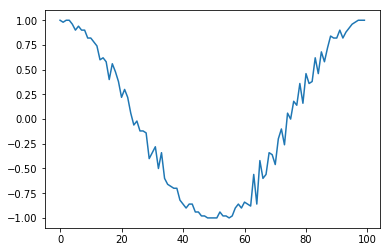

In [51]:
import matplotlib.pyplot as plt
plt.plot(result)

サンプリングによるノイズを含むものの1から-1まで綺麗に干渉している。サンプリング回数を10000にすると、

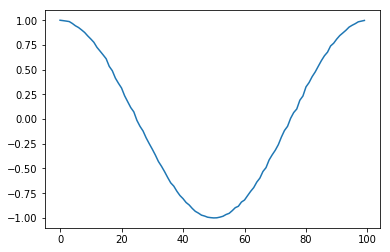

In [16]:
result = []
for i in range(100):
    phase = i*np.pi/100.0
    result.append(interferometer(phase,10000))

import matplotlib.pyplot as plt
plt.plot(result)

サンプリングによるノイズがだいぶ小さくなった。

### ノイズの導入
量子回路におけるノイズを導入しよう。qulacsではノイズ（一般的なCPTP写像）の実装がなされている。あらかじめ定義されているノイズは、`BitFlipNoise`, `DephasingNoise`, `IndepenedentXZNoise`, `DepolarizingNoise`。位相緩和、`DephasingNoise`を入れてみよう。

In [17]:
from qulacs.gate import DephasingNoise

In [18]:
nqubits = 1
state = QuantumState(nqubits)
state.set_zero_state
H(0).update_quantum_state(state)
DephasingNoise(0,0.5).update_quantum_state(state)
print(state.get_vector())

[0.70710678+0.j 0.70710678+0.j]


位相緩和が入った干渉をみてみよう。

In [44]:
def noisy_interferometer(phase,num_sample,dephasing_rate):
    nqubits = 1
    state = QuantumState(nqubits)


    mean_value =0.0
    for i in range(num_sample):
        state.set_zero_state()
        circuit = QuantumCircuit(nqubits)
        H(0).update_quantum_state(state)
        RZ(0,phase).update_quantum_state(state)
        DephasingNoise(0,dephasing_rate).update_quantum_state(state)
        H(0).update_quantum_state(state)
        P0(0).update_quantum_state(state)

        prob_zero = state.get_norm()
        mean_value = mean_value +(1-2*sample(prob_zero))
    mean_value = mean_value/num_sample
    return  mean_value

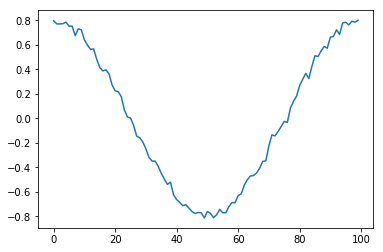

In [50]:
result = []
for i in range(100):
    phase = i*np.pi/100.0
    result.append(noisy_interferometer(phase,1000,0.1))

plt.plot(result)

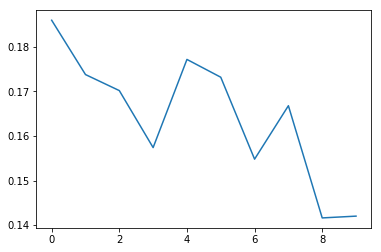

In [91]:
result = []
for i in range(10):
    result.append(noisy_interferometer(np.pi/4.0-0.1,10000,0.05+0.01*i))
plt.plot(result)

In [92]:
print(result)

[0.186, 0.1738, 0.1702, 0.1574, 0.1772, 0.1732, 0.1548, 0.1668, 0.1416, 0.142]


### データをフィッティングしてノイズパラメータが0のときの期待値を外挿して求める

In [93]:
a, b = np.polyfit( [0.05+0.01*i for i in range(10)],result, 1)

In [94]:
print(a,b)

-0.3940606060606056 0.20173575757575746


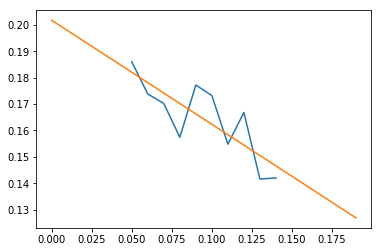

In [95]:
plt.plot([0.05+0.01*i for i in range(10)],result)
x = np.arange(0, 0.2, 0.01)
y = a*x+b
plt.plot(x,y)

ノイズパラメータが0の時の期待値は、0.2017。5%のノイズのあるサンプリング結果は、

In [98]:
noisy_interferometer(np.pi/4.0-0.1,10000,0.05)

0.1852

理想的な結果は、

In [100]:
def ideal_interferometer(phase):
    nqubits = 1
    state = QuantumState(nqubits)
    state.set_zero_state
    
    circuit  = QuantumCircuit(nqubits)
    circuit.add_H_gate(0)
    angle = phase
    circuit.add_gate(RZ(0,angle))
    circuit.add_H_gate(0)
    circuit.update_quantum_state(state)
    
    Pauli_product = "Z 0"
    observable = Observable(nqubits)
    observable.add_operator(1.0,Pauli_product)
    ex_value = observable.get_expectation_value(state)
    return  ex_value

In [101]:
ideal_interferometer(np.pi/4.0-0.1)

0.1986693307950615

ノイズ補償による効果が確認された。

### 指数関数によるフィッティング
ゲートが複数出てくる場合におけるノイズの補償は指数関数を用いてフィッティングする。ゲートが複数適当な演算を定義する。

In [9]:
def ideal_circuit():
    np.random.seed(0) #乱数のシードを固定する

    nqubits = 5
    depth = 5
    
    angles = [np.random.random() for i in range(nqubits*depth)]
    state = QuantumState(nqubits)
    state.set_zero_state
    
    circuit  = QuantumCircuit(nqubits)
    l=0
    for j in range(depth):
        for i in range(nqubits):
            circuit.add_H_gate(i)
            circuit.add_gate(RZ(i,angles[l]*np.pi))
            l=l+1;

        for i in range(nqubits-1):
            circuit.add_gate(CZ(i,i+1))
            
    for i in range(nqubits):
            circuit.add_H_gate(i)
    
    circuit.update_quantum_state(state)
    
    Pauli_product = "Z 0"
    observable = Observable(nqubits)
    observable.add_operator(1.0,Pauli_product)
    ex_value = observable.get_expectation_value(state)
    return  ex_value

In [10]:
ideal_circuit()

0.72122198021183

ノイズを含んだサンプリングバージョンを定義する。

In [19]:
from qulacs.gate import DepolarizingNoise

def noisy_circuit(num_sample,depo_rate):
    nqubits = 5
    depth = 5
    np.random.seed(0) #乱数のシードを固定する
    angles = [np.random.random() for i in range(nqubits*depth)]
    state = QuantumState(nqubits)

    mean_value =0.0
    
    for k in range(num_sample):
        circuit  = QuantumCircuit(nqubits)
        state.set_zero_state()
        l=0
        for j in range(depth):
            for i in range(nqubits):
                H(i).update_quantum_state(state)
                DepolarizingNoise(i,depo_rate).update_quantum_state(state)
                
                RZ(i,angles[l]*np.pi).update_quantum_state(state)
                DepolarizingNoise(i,depo_rate).update_quantum_state(state)
                l=l+1

            for i in range(nqubits-1):
                CZ(i,i+1).update_quantum_state(state)
                DepolarizingNoise(i,depo_rate).update_quantum_state(state)
                DepolarizingNoise(i+1,depo_rate).update_quantum_state(state)

        for i in range(nqubits):
            H(i).update_quantum_state(state)

        P0(0).update_quantum_state(state)

        prob_zero = state.get_norm()

        mean_value = mean_value +(1-2*sample(prob_zero))
    
    mean_value = mean_value/num_sample
    return  mean_value

In [22]:
noisy_circuit(1000,0)

0.75

0
1
2
3
4
5
6
7
8


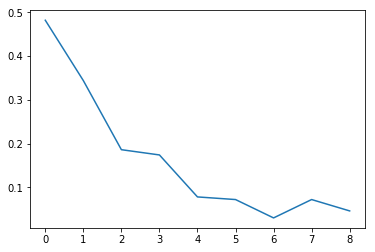

In [29]:

result = []
for i in range(9):
    print(i)
    result.append(noisy_circuit(1000,0.01+0.01*i))
plt.plot(result)

とりあえず、線形でフィティングしておこう

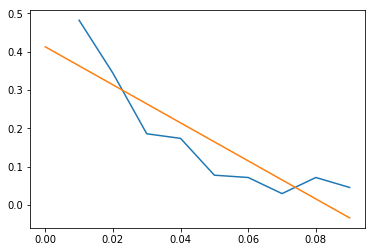

In [33]:
a, b = np.polyfit( [0.01+0.01*i for i in range(9)],result, 1)
plt.plot([0.01+0.01*i for i in range(9)],result)
x = np.arange(0, 0.1, 0.01)
y = a*x+b
plt.plot(x,y)

In [34]:
print(b)

0.412722222222222


理想的な値に全然一致していない。指数関数でフィッティングしておこう。

In [35]:
def nonlinear_fit(w,a,b):
    return  a*(1-w)**b
from scipy.optimize import curve_fit
param, cov = curve_fit(nonlinear_fit,[0.01+0.01*i for i in range(9)] , result)

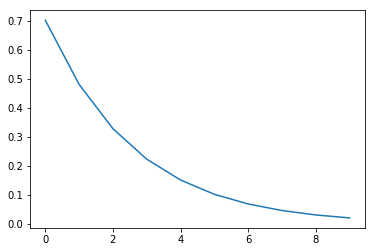

In [36]:
plt.plot(nonlinear_fit(x,param[0],param[1]))

In [40]:
param[0]

0.7023578652992781

理想的な値に近くなった（ノイズ補償の効果があった）。